# Mall Customers Dataset

The following task is an unsupervised learning one - clustering using the Mall Customers Dataset. The main objective of this project is to successfully perform a clustering task using custom-made K-Means Clustering algorithm.

**Main Objectives and Tasks:**
- <u>Import the data</u>
- <u>Exploratory Data Analysis (EDA)</u>
- <u>Preprocess the data.</u>
- <u>Build K-Means Clustering</u> 
- <u>Hyperparameter Tuning (n_clusters) with Elbow Plot.</u>
- <u>Plot the K-Means clusters with different colors.</u>
- <u>Predict on new data</u>
- <u>Interpret and provide conclusions.</u>

**Extra:**
- <u>Implement the K-Means Clustering model from scratch.</u>
- <u>Visualizing cluster centroids with diamond marker. Choose s=50 or another appropriate size.</u>

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## K-Means Implementation

Below is the implementation of the **K-Means** clustering algorithm with the n_clusters, random_seed, max_iter hyperparameters, and tol. 

The model will implement **block coordinate descent**, alternating between minimizing with respect to the assignments and to the cluster centers. The assignment are one-hot encoded vectors that determine the cluster each instance belongs to (1) and does not belong to (0). Convergence will be determined by inertia and tolerance.

Note: this model is not the same as the base scikit-learn KMeans algorithm, one key difference is that it has random initialization, not k-means++ initialization.

In [1091]:
class K_Means():
    """
    This is a custom implementation of the K-Means clustering algorithm.

    Parameters:
    - self.n_clusters is the number of clusters, k, the model will create.
    - self.random_seed sets the seed for the random initialization of centroids.
    - self.max_iter determines the maximum number of iterations the cluster will run for. If None, other metrics will be used
    to ensure stopping once convergence is attained.
    - self.tol determines the convergence threshold.
    - self.r are the cluster assignments for each instance.
    - self.m are the cluster centers.
    - self.inertia is the inertia of the current model

    """
    def __init__(self, n_clusters=3, random_seed=42, max_iter=20, tol=1e-4):
        self.n_clusters = n_clusters
        self.random_state = random_seed
        self.max_iter = max_iter
        self.tol = tol
        self.m = None
        self.r = None
        self.inertias = []

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        np.random.seed(self.random_state)
        # X is the dataset of shape (instances, features) or N x D
        # Initialize centroids and assignments
        min_ranges = np.min(X, axis=0)
        max_ranges = np.max(X, axis=0)
        
        self.m = np.random.uniform(low=min_ranges, high=max_ranges, size=(self.n_clusters, X.shape[1]))
        self.r = np.zeros((X.shape[0], self.n_clusters))

        for i in range(self.max_iter):
            distances = self.assignments(X)
            self.refitting(X)
            self.calculate_inertia(distances)
            if self.check_convergence(i):
                break

    def calculate_inertia(self, d):
        # Squared distances of points with every cluster
        self.inertias.append(np.sum(self.r*d))
        
    def check_convergence(self, i):
        if i >= 1:
            return np.abs(self.inertias[-1] - self.inertias[-2]) <= self.tol
        else:
            return False

    def assignments(self, X):
        # Euclidean distances for minimizing squared distance of instances to cluster center. 
        # reshape(1, -1) for row vectors, reshape(-1, 1) to create column vectors.
        distances = np.sum(self.m**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1).reshape(1, -1) - 2*self.m@X.T
            
        # Get cluster indices that minimize the euclidean distance between cluster center and instance.
        indices = np.argmin(distances.T, axis=1)
        self.r[:, :] = 0
        self.r[np.arange(self.r.shape[0]), indices] = 1

        return distances.T

    def refitting(self, X):
        self.m = (self.r.T @ X) / (np.sum(self.r, axis=0).reshape(-1, 1)+1e-05) # add a small number to prevent division by 0
        # Division by 0 occurs due to empty clusters when k is large.

    def predict(self, X_new):
        # Convert to numpy array
        if isinstance(X_new, pd.DataFrame):
            X_new = X_new.values

        distances = np.sum(self.m**2, axis=1).reshape(-1, 1) + np.sum(X_new**2, axis=1).reshape(1, -1) - 2*self.m@X_new.T
            
        # Get cluster indices that minimize the euclidean distance between cluster center and instance.
        indices = np.argmin(distances.T, axis=1)
        
        return indices

    def get_cluster_centers(self):
        return self.m
        

## Importing the Dataset

In [9]:
## Importing the Dataset
mall_customers = pd.read_csv("Mall_Customers.csv")

In [11]:
mall_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [13]:
mall_customers.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [15]:
mall_customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


The model has 5 features, and the aim of the project is to perform an unsupervised learning task on this dataset: **Clustering**. Given that there is no missing data and the data is clean, EDA will be performed. As this is an unsupervised task, there will be no train/test split.

## Exploratory Data Analysis (EDA)

For this dataset, the task is to segment the customers based on their spending habits, annual income, and other features. Using this information, the mall can see if there are groups of customers with similar underlying patterns and behaviours. 

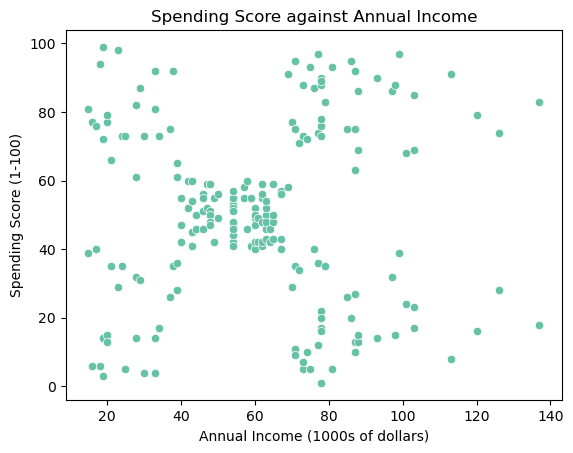

In [274]:
sns.scatterplot(x=mall_customers["Annual Income (k$)"], y=mall_customers["Spending Score (1-100)"], color="#66c2a5")
plt.title("Spending Score against Annual Income")
plt.xlabel("Annual Income (1000s of dollars)")
plt.ylabel("Spending Score (1-100)")
plt.show()

Using the annual income against spending score, it seems that there will be approximately 5 clusters. This will later be verified with an elbow plot and other metrics, such as the mean silhouette score.

Now, let's take a look at both sex and age and their relationship to spending score.

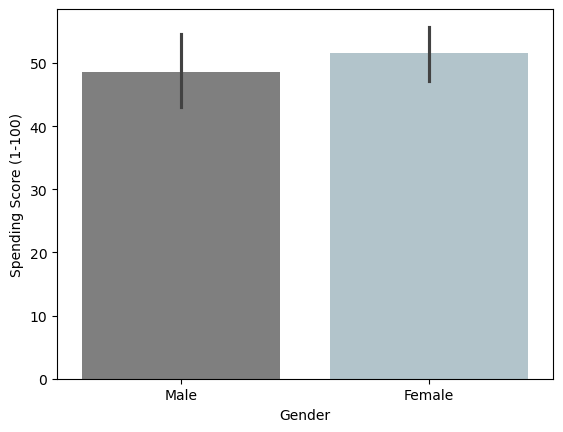

In [282]:
sns.barplot(data=mall_customers, x="Gender", y="Spending Score (1-100)", hue="Gender", legend=False, palette=["#7f7f7f", "#AEC6CF"])
plt.show()

Spending scores for both genders are very similar, with women being slightly higher.

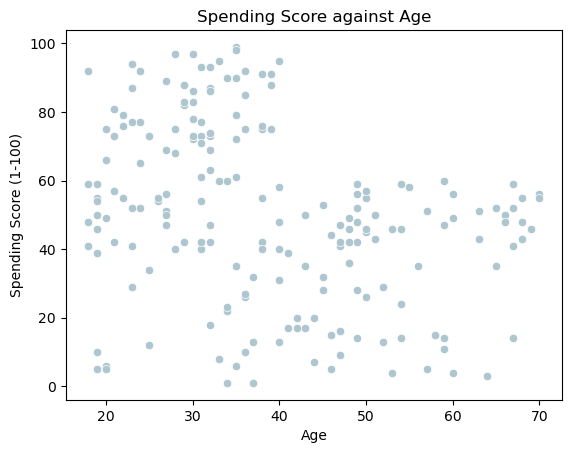

In [276]:
sns.scatterplot(x=mall_customers["Age"], y=mall_customers["Spending Score (1-100)"], color="#AEC6CF")
plt.title("Spending Score against Age")
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")
plt.show()

Spending score appears to be influenced by age. Younger people, that is below the age of 40, have on average a much higher spending score on average than older customers.

Despite this relationship, it is not clear visually how many clusters there are. Given that this is the case, clustering will be done on spending score and annual income.

## Preprocessing the Data

All numerical data will be scaled as K-Means Clustering uses a distance algorithm and is therefore sensitive to differences in scale between features.

In [40]:
# Convert to a np.array
mall_array = mall_customers.values

In [416]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
cluster_data = mall_array[:, 3:5]

cluster_data_scaled = standard_scaler.fit_transform(cluster_data)

## Building the Model

In [1018]:
from sklearn.cluster import KMeans

xs = cluster_data_scaled[:, 0]
ys = cluster_data_scaled[:, 1]
model = KMeans(n_clusters=5, random_state=21)
model.fit(cluster_data_scaled)
labels = model.predict(cluster_data_scaled)

## Plotting the Clusters

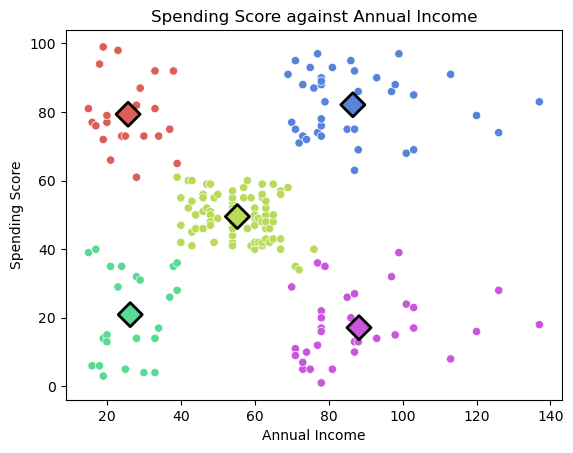

In [1021]:
palette = sns.color_palette("hls", 5)
centroids = standard_scaler.inverse_transform(model.cluster_centers_)
unscaled_data = standard_scaler.inverse_transform(cluster_data_scaled)
xs = unscaled_data[:, 0]
ys = unscaled_data[:, 1]
sns.scatterplot(x=xs, y=ys, hue=labels, legend=False, palette=palette)
plt.title("Spending Score against Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker="D", s=150, c=palette, edgecolor="black", linewidth=2)
plt.show()

From this graph, we can conclude that there are five different mall customer groups:
- Low spending score and low annual income customers.
- Low spending score and high annual income customers.
- High spending score and low annual income customers.
- High spending score and high annual income customers.
- Customers with a medium spending score and medium annual income.

The mall can use this information about the annual income and spending score of the five different groups of customers to employ appropriate marketing strategies for the most important groups.

## Hyperparameter Tuning

Find the optimal number of clusters, k, by plotting an elbow plot and looking at a silhouette plot.

In [441]:
from sklearn.metrics import silhouette_score

n_clusters=[2, 3, 4, 5, 6, 7, 8, 9, 10]
models = []
inertias = []
silhouette_scores = []
for k in n_clusters:
    current_model = KMeans(n_clusters=k, random_state=21)
    current_model.fit(cluster_data_scaled)
    score = silhouette_score(cluster_data_scaled, current_model.labels_)
    models.append(current_model)
    inertias.append(current_model.inertia_)
    silhouette_scores.append(score)
    

Now, plotting an elbow plot using the number of clusters of each model as the x axis and the inertias on the y axis will give some indication of the optimal number of clusters, k, for the algorithm. The same will be done for silhouette scores.

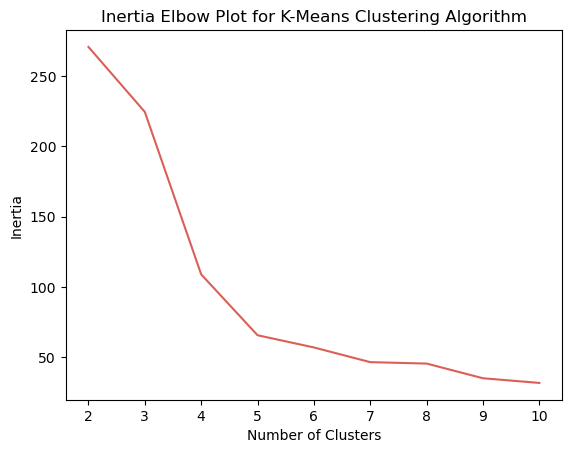

In [444]:
sns.lineplot(x=n_clusters, y=inertias)
plt.title("Inertia Elbow Plot for K-Means Clustering Algorithm")
plt.ylabel("Inertia")
plt.xlabel("Number of Clusters")
plt.show()

Based of the elbow plot, it seems like k=5 is the optimal number of clusters. Although 4 clusters could work as well. Plotting a silhouette scores against number of clusters plot should help to confirm the appropriate number.

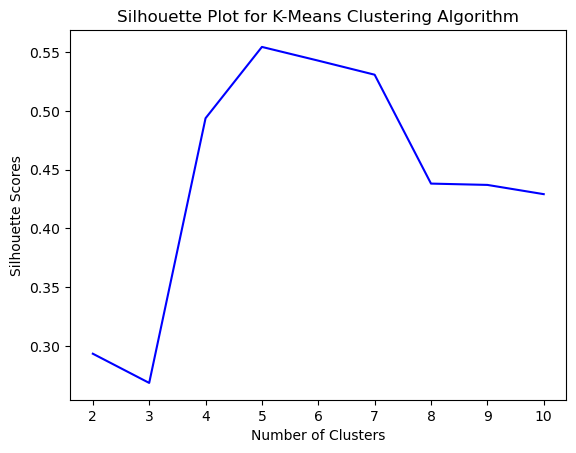

In [447]:
sns.lineplot(x=n_clusters, y=silhouette_scores, color="blue")
plt.title("Silhouette Plot for K-Means Clustering Algorithm")
plt.ylabel("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.show()

Note that silhouette scores can be interpreted as follows:
- 1 indicates the instances are well inside the cluster centers.
- 0 indicates they are close to the cluster boundaries.
- -1 indicates the instance is probably in the wrong cluster.

In other words, silhouette scores measure the quality of the clusters.

Based on the diagram, k = 5 is the best choice, but k=4 or k=7 could be tried. Let's visualize this.

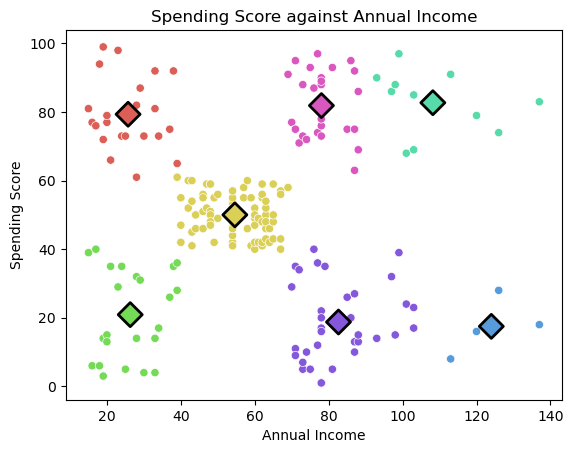

In [1033]:
palette = sns.color_palette("hls", 7)
centroids_7 = standard_scaler.inverse_transform(models[5].cluster_centers_)
labels_7 = models[5].labels_
sns.scatterplot(x=xs, y=ys, hue=labels_7, legend=False, palette=palette)
plt.title("Spending Score against Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.scatter(x=centroids_7[:, 0], y=centroids_7[:, 1], marker="D", s=150, c=palette, edgecolor="black", linewidth=2)
plt.show()

Using 7 cluster centers may provide high quality clusters, but it sacrifices interpretability. Does having 7 groups of different customers tell us more than 5? Given that there are two high annual income low spending score groups, and two high annual income high spending score groups, while the quality of clusters may have improved, the new groups defined are redundant and unnecessary.

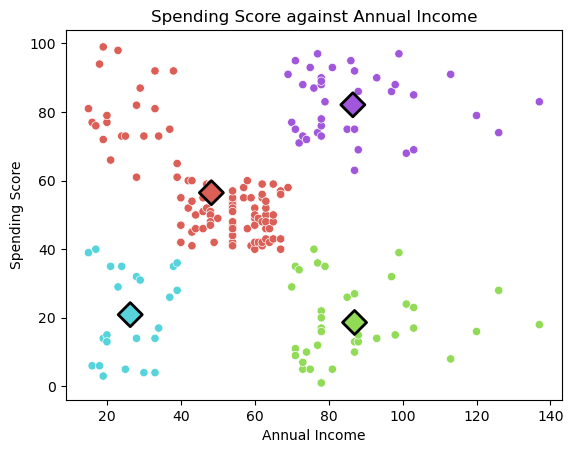

In [1031]:
palette = sns.color_palette("hls", 4)
centroids_4 = standard_scaler.inverse_transform(models[2].cluster_centers_ )
labels_4 = models[2].labels_
sns.scatterplot(x=xs, y=ys, hue=labels_4, legend=False, palette=palette)
plt.title("Spending Score against Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.scatter(x=centroids_4[:, 0], y=centroids_4[:, 1], marker="D", s=150, c=palette, edgecolor="black", linewidth=2)
plt.show()

On the other hand, using k=4 also means the clusters are of good quality, but an important group is neglected - low annual income and high spending score. Instead, this group is merged with another group - that of median spending score and annual income customers, which also sacrifices interpretability. Therefore, it's quite obvious that k=5 is the best (optimal) cluster choice for model interpretability.

## Prediction

In [460]:
# format is (age, annual income, spending score)
new_data = np.array([[19, 15, 39],
           [35, 35, 66],
           [26, 75, 11],
           [45, 120, 77],
           [31, 50, 40]])

new_data = new_data[:, 1:3]
new_data_scaled = standard_scaler.transform(new_data)

In [464]:
model.predict(new_data_scaled)

array([2, 0, 4, 3, 1], dtype=int32)

The model is able to place each of these customers into a group that best reflects their spending habits and annual income.

## Testing the Manual Implementation

In [1086]:
n_clusters=5
model_implemented = K_Means(n_clusters=n_clusters, max_iter=100, random_seed=42, tol=1e-4)
model_implemented.fit(cluster_data_scaled)
labels_implemented = model_implemented.predict(cluster_data_scaled)

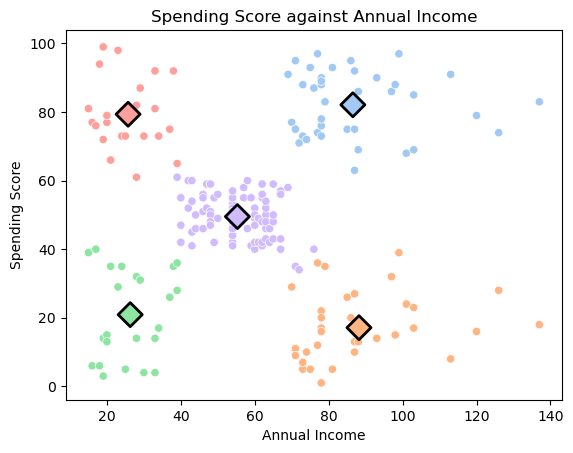

In [1088]:
palette = sns.color_palette("pastel", n_clusters)
centroids = standard_scaler.inverse_transform(model_implemented.get_cluster_centers())
unscaled_data = standard_scaler.inverse_transform(cluster_data_scaled)
xs = unscaled_data[:, 0]
ys = unscaled_data[:, 1]
sns.scatterplot(x=xs, y=ys, hue=labels_implemented, legend=False, palette=palette)
plt.title("Spending Score against Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker="D", s=150, c=palette, edgecolor="black", linewidth=2)
plt.show()